# Diabetic Retinopathy Detection
Diabetic retinopathy is the leading cause of blindness in the working-age population of the developed world. It is estimated to affect over 93 million people.

The need for a comprehensive and automated method of DR screening has long been recognized, and previous efforts have made good progress using image classification, pattern recognition, and machine learning. With color fundus photography as input, the goal of this competition is to push an automated detection system to the limit of what is possible – ideally resulting in models with realistic clinical potential. The winning models will be open sourced to maximize the impact such a model can have on improving DR detection.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [ ]:
import os
from getpass import getpass
import urllib
from google.colab import drive
from tqdm import tqdm

## Downloading the Kaggle dataset

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/../content/.kaggle/

In [ ]:
import json
import zipfile
import os

api_token = {"username":"danialsaeedi","key":"0e8b2b44d44c77da540a3be3f55a84e4"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

!chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!kaggle datasets download tanlikesmath/diabetic-retinopathy-resized

100% 7.25G/7.25G [01:10<00:00, 96.6MB/s]
100% 7.25G/7.25G [01:10<00:00, 110MB/s] 


In [ ]:
!unzip /content/{/content}/datasets/tanlikesmath/diabetic-retinopathy-resized/diabetic-retinopathy-resized.zip

## Analyzing the data



In [ ]:
df_train = pd.read_csv('trainLabels.csv')
df_train

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


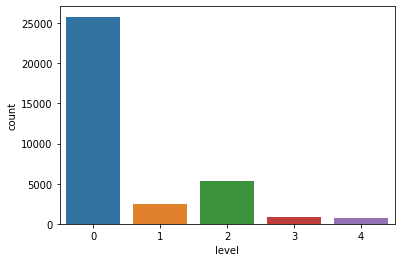

In [ ]:
sns.countplot(df_train['level'])

Because the labels are imbalanced, we split the data set in a stratified fashion, using this as the class labels.

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df_train.index.values, 
                                                  df_train.level.values, 
                                                  test_size=0.10, 
                                                  random_state=42, 
                                                  stratify=df_train.level.values)

df_train['data_type'] = ['not_set']*df_train.shape[0]
df_train.loc[X_train, 'data_type'] = 'train'
df_train.loc[X_val, 'data_type'] = 'test'
df_train

,image,level,data_type
0,10_left,0,train
1,10_right,0,train
2,13_left,0,train
3,13_right,0,train
4,15_left,1,test
...,...,...,...
35121,44347_right,0,test
35122,44348_left,0,train
35123,44348_right,0,test
35124,44349_left,0,train


In [ ]:
df_train.isnull().sum()

image        0
level        0
data_type    0
dtype: int64

In [ ]:
# Lenth of Training Set
len(df_train)/2

17563.0

In [ ]:
resized_train_path = '/content/resized_train/resized_train/'

## Separating training and validation set by their labels

In [ ]:
!mkdir Dataset/
!mkdir Dataset/train/
!mkdir Dataset/test/

In [ ]:
labels = df_train['level'].unique()
labels

array([0, 1, 2, 4, 3])

### Train/Test Label Folders

In [20]:
# Parent Directory path 
training_dir = '/content/Dataset/train/'
test_dir = '/content/Dataset/test/'
for label in labels :
  path_train = os.path.join(training_dir, str(label)) 
  path_test = os.path.join(test_dir, str(label)) 
  os.mkdir(path_train)
  os.mkdir(path_test)

In [22]:
from pathlib import Path
def separate_by_label(parent_dir, move_to, df, data_type = 'train') :
  for index, row in df.iterrows():
    if row['data_type'] == data_type :
      destination = move_to+str(row['level'])+'/'+ row['image'] + '.jpeg'
      Path(parent_dir + row['image'] + '.jpeg').rename(destination)
    else :
      continue

In [23]:
separate_by_label(resized_train_path,training_dir,df_train, data_type = 'train')
separate_by_label(resized_train_path,test_dir,df_train, data_type = 'test')

In [26]:
df_train[df_train['data_type'] == 'train'].to_csv (training_dir + 'trainLabels.csv', index = False, header=True)
df_train[df_train['data_type'] == 'test'].to_csv (test_dir + 'testLabels.csv', index = False, header=True)

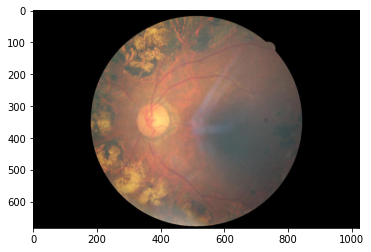

In [27]:
from matplotlib.image import imread
img = imread('/content/Dataset/train/4/10017_left.jpeg')
plt.imshow(img)

## Dataloader

In [28]:
import torchvision
from PIL import Image
from torch.utils.data import Dataset
import os
import pandas as pd

class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, base_image_dir, set_type='train', transforms=None, balance=True):

        self.transforms = transforms

        self.dataframe = pd.read_csv(os.path.join(base_image_dir, f'{set_type}Labels.csv'), dtype='str')

        self.dataframe['patient_id'] = self.dataframe['image'].map(lambda x: x.split('_')[0])
        self.dataframe['path'] = self.dataframe['image'].map(lambda x: os.path.join(base_image_dir,
                                                                                    '{}.jpeg'.format(x)))
        self.dataframe['exists'] = self.dataframe['path'].map(os.path.exists)
        self.dataframe['eye'] = self.dataframe['image'].map(lambda x: 1 if x.split('_')[-1] == 'left' else 0)
        self.dataframe.dropna(inplace=True)
        self.dataframe = self.dataframe[self.dataframe['exists']]
        self.exist_unbalance_count = self.dataframe.shape[0]

        if balance:
            g = self.dataframe.groupby('level')
            g = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
            self.dataframe = g

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]

        data = Image.open(row["path"])
        label = int(row["level"])
        if self.transforms is not None:
            data = self.transforms(data)
        # If the transform variable is not empty
        # then it applies the operations in the transforms with the order that it is created.
        return data, label

The <a href='https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22'>recommended normalization parameters</a> for mean and std per channel.

In [30]:
from torchvision import datasets, transforms, models
train_transform = transforms.Compose([
    transforms.RandomRotation(10),      # rotate +/- 10 degrees
    transforms.RandomHorizontalFlip(),  # reverse 50% of images
    transforms.Resize(224),             # resize shortest side to 224 pixels
    transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

In [35]:
train_loader = DiabeticRetinopathyDataset(training_dir,transforms=train_transform, set_type='train')
test_loader = DiabeticRetinopathyDataset(test_dir,transforms=test_transform, set_type='test')